In [1]:
install.packages("caret")
library(caret)

Installing package into 'C:/Users/ramsh/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'caret' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ramsh\AppData\Local\Temp\RtmpO6vZiy\downloaded_packages


Warning message:
"package 'caret' was built under R version 4.3.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Loading required package: lattice



In [2]:
data <- read.csv("listings_newyork.csv")

In [3]:
head(data)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>
1,8.167834e+17,Cool studio 3 min from subway!,47125955,Rebeca,Queens,Long Island City,40.76133,-73.92676,Entire home/apt,110,30,9,2023-09-25,0.96,2,363,9,
2,8.686040e+06,LARGE MANHATTAN ONE BEDROOM,45608786,Virginia,Manhattan,Inwood,40.85999,-73.92850,Entire home/apt,NA,30,5,2015-11-22,0.05,1,0,0,
3,1.242678e+07,TH BRKLYN,7963317,Rob,Brooklyn,Boerum Hill,40.68834,-73.98601,Private room,NA,30,0,,NA,1,0,0,
4,2.267152e+07,55 washington,3428456,Yoon,Brooklyn,DUMBO,40.70149,-73.98886,Private room,NA,30,0,,NA,1,0,0,
5,3.577696e+07,luxury apt in long lsland city 1min to subway,221012726,Lyn,Queens,Long Island City,40.74901,-73.93898,Private room,NA,30,1,2019-07-31,0.02,1,0,0,
6,5.233178e+07,Queen Bedroom A w/Private Bathroom in #608,305240193,June,Manhattan,Harlem,40.80485,-73.94918,Private room,NA,30,0,,NA,320,189,0,


In [4]:
# Columns to drop
columns_to_drop <- c('name', 'host_name', 'last_review', 'reviews_per_month', 'license', 'host_id')

# Drop columns from the data frame
data <- data[, setdiff(names(data), columns_to_drop)]

In [5]:
# Handle missing values
mean_price <- mean(data$price, na.rm = TRUE)
data$price[is.na(data$price)] <- mean_price

In [6]:
# Columns to drop
columns_to_drop <- c('name', 'host_name', 'last_review', 'reviews_per_month', 'license', 'host_id')

# Drop columns from the data frame
data <- data[, setdiff(names(data), columns_to_drop)]


In [7]:
head(data)

,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,8.167834e+17,Queens,Long Island City,40.76133,-73.92676,Entire home/apt,110.0000,30,9,2,363,9
2,8.686040e+06,Manhattan,Inwood,40.85999,-73.92850,Entire home/apt,205.2729,30,5,1,0,0
3,1.242678e+07,Brooklyn,Boerum Hill,40.68834,-73.98601,Private room,205.2729,30,0,1,0,0
4,2.267152e+07,Brooklyn,DUMBO,40.70149,-73.98886,Private room,205.2729,30,0,1,0,0
5,3.577696e+07,Queens,Long Island City,40.74901,-73.93898,Private room,205.2729,30,1,1,0,0
6,5.233178e+07,Manhattan,Harlem,40.80485,-73.94918,Private room,205.2729,30,0,320,189,0


In [8]:
remove_outliers_iqr <- function(data, cols) {
  for (col in cols) {
    Q1 <- quantile(data[[col]], 0.25, na.rm = TRUE)
    Q3 <- quantile(data[[col]], 0.75, na.rm = TRUE)
    IQR <- Q3 - Q1
    lower_bound <- Q1 - 1.5 * IQR
    upper_bound <- Q3 + 1.5 * IQR
    data <- data[data[[col]] >= lower_bound & data[[col]] <= upper_bound, ]
  }
  return(data)
}

In [9]:
numerical_cols <- c('latitude', 'longitude', 'price', 'minimum_nights', 
                    'number_of_reviews', 'calculated_host_listings_count', 
                    'availability_365', 'number_of_reviews_ltm')

data_cleaned <- remove_outliers_iqr(data, numerical_cols)

In [10]:
# Label encode categorical variables
cols <- c("neighbourhood_group", "neighbourhood", "room_type")

label_encode <- function(df, columns_to_encode) {
  for (column in columns_to_encode) {
    df[[column]] <- as.numeric(factor(df[[column]]))
  }
  return(df)
}

In [11]:
data_cleaned <- label_encode(data_cleaned, cols)

In [12]:
# Check for missing values in the entire dataset
missing_values <- colSums(is.na(data))

# Print columns with missing values
print(missing_values[missing_values > 0])


named numeric(0)


In [13]:
# Correlation with other numeric variables
numeric_cols <- c('latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                   'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm')

correlation <- sapply(data_cleaned[, numeric_cols], function(x) cor(data_cleaned$price, x))
correlation <- sort(correlation, decreasing = TRUE)
print(correlation)

Warning message in cor(data_cleaned$price, x):
"the standard deviation is zero"


                      latitude              number_of_reviews 
                    0.01835642                    -0.01032611 
         number_of_reviews_ltm                      longitude 
                   -0.25339785                    -0.25929166 
calculated_host_listings_count               availability_365 
                   -0.38723367                    -0.51967533 


In [15]:
library(dplyr)

X <- data_cleaned %>%
  select(-price, -number_of_reviews, -number_of_reviews_ltm, -neighbourhood)
y <- data_cleaned$price

# Split the data into training and testing sets
set.seed(42)  # Set seed for reproducibility
train_index <- sample(1:nrow(data_cleaned), 0.8 * nrow(data_cleaned))  # 80% training data
X_train <- X[train_index, ]
X_test <- X[-train_index, ]
y_train <- y[train_index]


# Split the data into features (X) and target variable (y)
X <- data_cleaned %>%
  select(-price, -number_of_reviews, -number_of_reviews_ltm, -neighbourhood)
y <- data_cleaned$price

# Split the data into training and testing sets
set.seed(42)  # Set seed for reproducibility
train_index <- sample(1:nrow(data_cleaned), 0.7 * nrow(data_cleaned))  # 70% training data
X_train <- X[train_index, ]
X_test <- X[-train_index, ]
y_train <- y[train_index]
y_test <- y[-train_index]

# Initialize the StandardScaler
scaler <- preProcess(X_train, method = c("center", "scale"))

# Fit and transform the training data
X_train_scaled <- predict(scaler, X_train)

# Transform the testing data using the same scaler
X_test_scaled <- predict(scaler, X_test)

# Initialize and train the KNN regressor
k <- 9  # Number of neighbors
knn_regressor <- train(
  x = X_train_scaled,
  y = y_train,
  method = "knn",
  trControl = trainControl(method = "cv", number = 5),
  tuneGrid = data.frame(k = k)
)

# Make predictions on the testing set
y_pred <- predict(knn_regressor, newdata = X_test_scaled)

# Evaluate the model using Mean Squared Error (MSE)
mse <- mean((y_test - y_pred)^2)
cat("Mean Squared Error:", mse, "\n")

# Calculate Root Mean Squared Error (RMSE)
rmse <- sqrt(mse)
cat("Root Mean Squared Error:", rmse, "\n")

# Calculate R-squared (R2)
r2 <- 1 - (sum((y_test - y_pred)^2) / sum((y_test - mean(y_test))^2))
cat("R-squared (R2):", r2, "\n")

Warning message:
"package 'dplyr' was built under R version 4.3.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message in preProcess.default(X_train, method = c("center", "scale")):
"These variables have zero variances: minimum_nights"


Mean Squared Error: 1279.845 
Root Mean Squared Error: 35.77492 
R-squared (R2): 0.5732106 


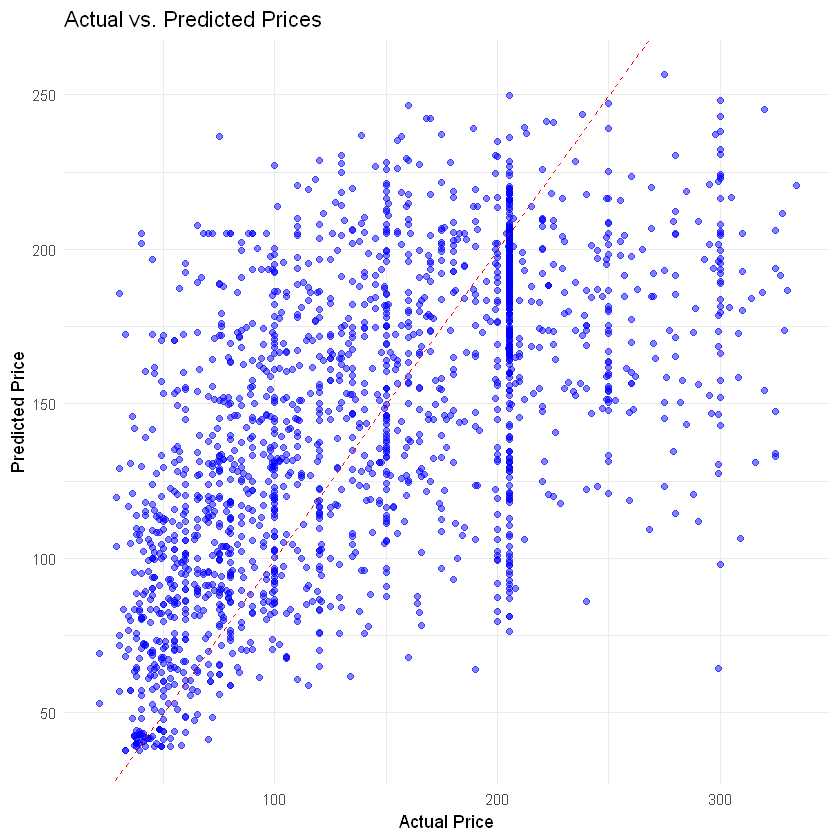

In [16]:
library(ggplot2)


df <- data.frame(Actual = y_test, Predicted = y_pred)

ggplot(df, aes(x = Actual, y = Predicted)) +
  geom_point(color = "blue", alpha = 0.5) +  # Scatter plot points
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +  # Diagonal line
  labs(title = "Actual vs. Predicted Prices", x = "Actual Price", y = "Predicted Price") +  # Labels
  theme_minimal() 